## PCA of DR7 QSO Data ##
Stephen Bailey, LBL, December 2016

This notebook uses https://github.com/sbailey/empca and SDSS DR7 data compiled by Yue Shen at http://quasar.astro.illinois.edu/repo/data/dr7_mfica_list.fits

In [1]:
import numpy as np
from astropy.io import fits
import empca
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#- Load data
dx = fits.getdata('dr7_mfica_list.fits')
flux = dx['FLUX_NORM'][0]
err = dx['ERR_NORM'][0]
weights = 1/err**2
wave = dx['RESTWAVE'][0]
plate = dx['PLATE'][0]
mjd = dx['MJD'][0]
fiber = dx['FIBER'][0]

In [3]:
#- Perform Expectation Maximization PCA with and without weights
p1 = empca.empca(flux, nvec=10, niter=10)
p2 = empca.empca(flux, weights=weights, nvec=10, niter=10)

       iter        R2             rchi2
EMPCA  1/10       0.22117245      1.38247968
EMPCA  2/10       0.96238214      0.00598812
EMPCA  3/10       0.97419005      0.00410843
EMPCA  4/10       0.97608527      0.00380675
EMPCA  5/10       0.97648695      0.00374281
EMPCA  6/10       0.97663057      0.00371995
EMPCA  7/10       0.97670739      0.00370772
EMPCA  8/10       0.97675346      0.00370038
EMPCA  9/10       0.97678119      0.00369597
EMPCA 10/10       0.97679780      0.00369333
R2: 0.976837417491
       iter        R2             rchi2
EMPCA  1/10       0.01409109    748.05253384
EMPCA  2/10       0.90321692      5.59869913
EMPCA  3/10       0.96631641      2.09192515
EMPCA  4/10       0.97272268      1.68087164
EMPCA  5/10       0.97390282      1.60795621
EMPCA  6/10       0.97428402      1.58739884
EMPCA  7/10       0.97443990      1.58037292
EMPCA  8/10       0.97450876      1.57812092
EMPCA  9/10       0.97453345      1.57826103
EMPCA 10/10       0.97453273      1.57982152
R

### Eigenvectors, eigenvalues, model ###
The PCA objects have the eigenvectors $V$, coefficients of the fit $C$, and the model of the input data $M = VC$

In [4]:
m1 = p1.coeff.dot(p1.eigvec)
np.allclose(m1, p1.model)

True

### Save the models and coefficients ###

In [5]:
def writepca(filename, pca):
    fits.writeto(filename, pca.eigvec, clobber=True)
    fits.append(filename, pca.coeff)

writepca('unweighted-qsopca-{}.fits'.format(p1.nvec), p1)
writepca('weighted-qsopca-{}.fits'.format(p1.nvec), p2)

### Weighted vs. unweighted PCA comparison ###

The resulting eigenvectors are similar, and thus the
$\chi^2$ for the weighted vs. unweighted PCA are pretty similar for this high $S/N$ training set

(-0.151, 0.151)

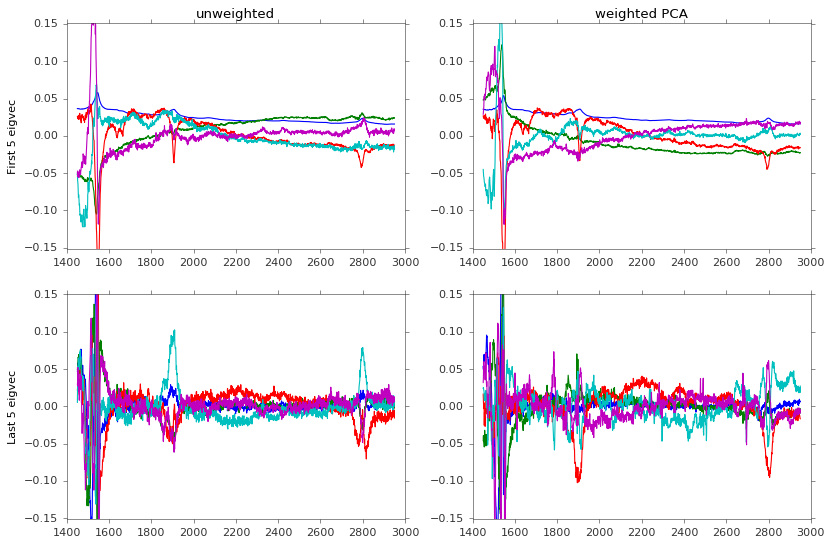

In [7]:
#- Plot the eigenvectors for each case
figure(figsize=(12,8))
for i in range(5):
    subplot(221); plot(wave, p1.eigvec[i])
    subplot(222); plot(wave, p2.eigvec[i])
    subplot(223); plot(wave, p1.eigvec[i+5])
    subplot(224); plot(wave, p2.eigvec[i+5])


subplot(221); ylim(-0.151, 0.151); title('unweighted'); ylabel('First 5 eigvec')
subplot(222); ylim(-0.151, 0.151); title('weighted PCA')
subplot(223); ylim(-0.151, 0.151); ylabel('Last 5 eigvec')
subplot(224); ylim(-0.151, 0.151)

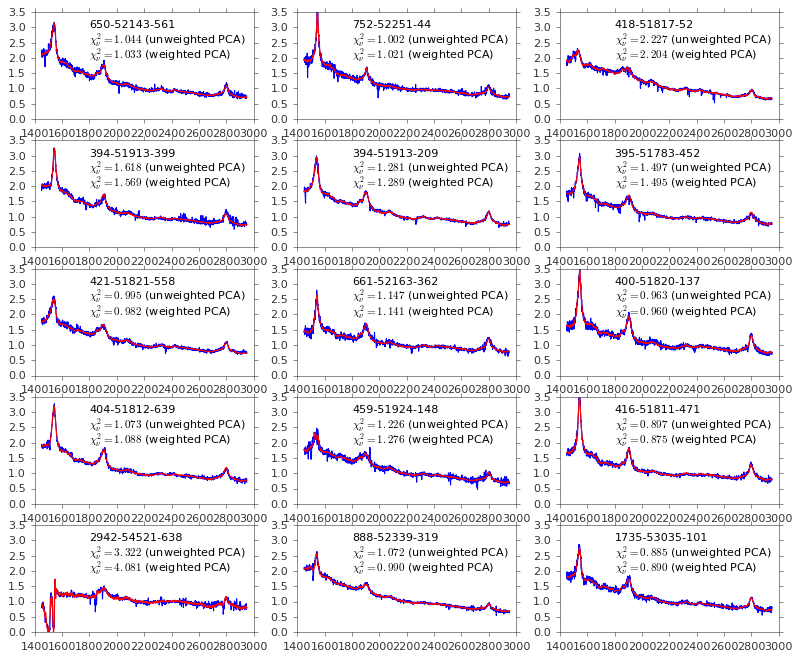

In [8]:
#- Plot some example fits
figure(figsize=(12,10))
nspec = 15
for i in range(nspec):
    subplot(nspec//3, 3, i+1)
    plot(wave, flux[i], 'b-')
    plot(wave, p1.model[i], 'r-')
    chi_unweighted = (flux[i] - p1.model[i]) / err[i]
    rchi2_unweighted = np.sum(chi_unweighted**2) / (len(flux[i]) - p1.nvec)
    chi_weighted = (flux[i] - p2.model[i]) / err[i]
    rchi2_weighted = np.sum(chi_weighted**2) / (len(flux[i]) - p2.nvec)
    text(1800, 3.0, '{}-{}-{}'.format(plate[i], mjd[i], fiber[i]))
    text(1800, 2.5, r'$\chi^2_\nu = {:.3f}$ (unweighted PCA)'.format(rchi2_unweighted))
    text(1800, 2.0, r'$\chi^2_\nu = {:.3f}$ (weighted PCA)'.format(rchi2_weighted))
    ylim(0.0, 3.5)

### Testing model applied to noisier data ###

In [9]:
#- Add some noise to the data
noisyflux = flux + np.random.normal(scale=3*err)
noisyerr = np.sqrt(10) * err
noisyweights = 1/noisyerr**2

In [10]:
#- Fit the unweighted PCA model to the new noisy data
from copy import copy
px = copy(p1)
px.set_data(noisyflux, noisyweights)
px.solve_model()

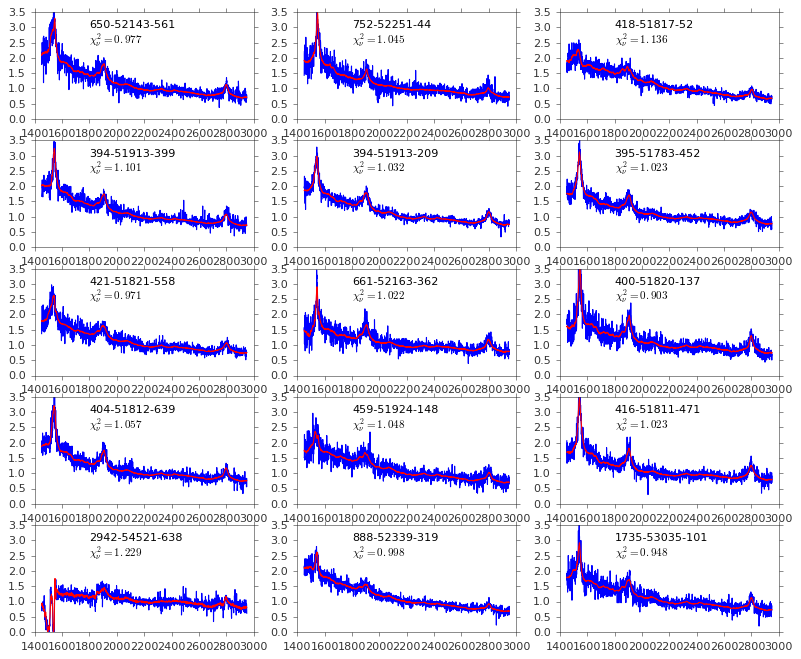

In [11]:
#- How'd we do?
figure(figsize=(12,10))
nspec = 15
for i in range(nspec):
    subplot(nspec//3, 3, i+1)
    plot(wave, noisyflux[i], 'b-')
    plot(wave, px.model[i], 'r-')
    chi = (noisyflux[i] - px.model[i]) / noisyerr[i]
    rchi2 = np.sum(chi**2) / (len(noisyflux[i]) - px.nvec)
    text(1800, 3.0, '{}-{}-{}'.format(plate[i], mjd[i], fiber[i]))
    text(1800, 2.5, r'$\chi^2_\nu = {:.3f}$'.format(rchi2))
    ylim(0.0, 3.5)